In [ ]:
# Ryan Chen
# sy37chen
# 20830005

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from pprint import pprint
from collections import defaultdict

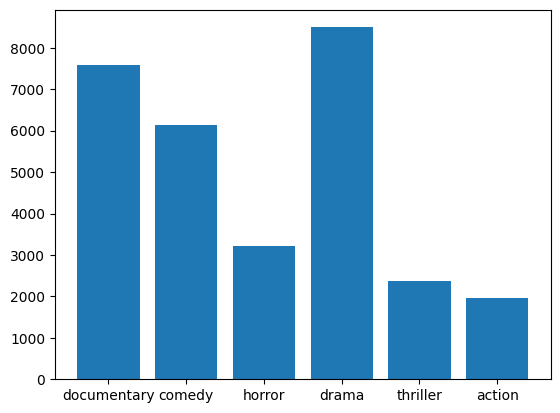

In [2]:
encoding = {"action":0,"comedy":1,"documentary":2,"drama":3,"horror":4,"thriller":5}
decoding = {0:"action",1:"comedy",2:"documentary",3:"drama",4:"horror",5:"thriller"}
genres = defaultdict(int)
training = pd.read_csv('train.csv', header=0)

genre_label = []
labels_df = training['genre']

for _, g in labels_df.items():
    genres[g] += 1
    genre_label.append(encoding[g])

# weights of each class (for random dataloader later)
weights = []
for count in genres.values():
    weights.append((1 - count/len(labels_df))**2.5)

weights[5] += 0.005
weights[0] += 0.005

validation_genre = []
validation_df = pd.read_csv('validate.csv', header=0)
validation_labels_df = validation_df['genre']
validation_genres_count = defaultdict(int)
for _, genre in validation_labels_df.items():
    genres[genre] += 1
    validation_genres_count[genre]+= 1
    validation_genre.append(encoding[genre])
plt.bar(genres.keys(), genres.values())
plt.show()
# test data
test_df = pd.read_csv('test.csv', header=0, index_col=0)

Part A: In both the training and validation sets, there is a much higher number of comedies, documentaries, and dramas than the other 3 classes of film.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

torch.cuda.empty_cache()

# feature_tensor = torch.tensor(training.drop(columns=['genre']).values, dtype=torch.double, device=device)
label_tensor = torch.tensor(genre_label, dtype=torch.long, device=device)

dataset = TensorDataset(torch.tensor(training.drop(columns=['genre']).values, dtype=torch.double, device=device), label_tensor)
# sample_weights = torch.tensor(weights, device=device)[label_tensor]
weighted_sampler = WeightedRandomSampler(weights=torch.tensor(weights, device=device)[label_tensor], num_samples=len(dataset), replacement=True)

dataloader = DataLoader(dataset, 64, sampler=weighted_sampler)

v_feature_tensor = torch.tensor(validation_df.drop(columns=['genre']).values, dtype=torch.double, device=device)
v_label_tensor = torch.tensor(validation_genre, dtype=torch.long, device=device)

t_feature_tensor = torch.tensor(test_df.values, dtype=torch.double, device=device)

cpu


In [4]:
# 1.c
class SimpleNeuralNet(nn.Module):
    def __init__(self, num_layers, num_nodes):
        super().__init__()
        layers = []

        prev_size = 300
        for _ in range(num_layers):
            layers.append(nn.Linear(prev_size, num_nodes, dtype=torch.float64))
            layers.append(nn.ReLU())
            prev_size = num_nodes

        layers.append(nn.Linear(prev_size, 6, dtype=torch.float64)) # Output layer
        layers.append(nn.Softmax(-1))

        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.stack(x)
        return logits

    def custom_train(self, dataloader, learning_rate, num_epochs, v_feature_tensor, v_label_tensor):
        lossFunc = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        train_error_list = []
        validation_error_list = []

        for i in range(num_epochs):
            running_error = 0
            running_sum = 0
            for inputs, label in dataloader:
                output = self(inputs)
                loss = lossFunc(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_error += torch.count_nonzero(torch.abs(torch.argmax(output, -1) - label))
                running_sum += len(inputs)


            # report train and validation loss
            validation_output = self(v_feature_tensor)
            train_error_list.append((running_error/running_sum).cpu())
            validation_error_list.append((torch.count_nonzero(torch.abs(torch.argmax(validation_output, -1) - v_label_tensor))/len(v_feature_tensor)).cpu())
            print(f"epock {i}")
            print(f"Training error: {train_error_list[-1]}")
            print(f"Validation error: {validation_error_list[-1]}")

        return train_error_list, validation_error_list


In [26]:
def get_stats(model, num_epoch, simple):
    if simple:
      train_error_list, validation_error_list = model.custom_train(dataloader, 0.001, num_epoch, v_feature_tensor, v_label_tensor)
    else:
      train_error_list, validation_error_list = model.custom_train(dataloader, 0.0003, num_epoch, v_feature_tensor, v_label_tensor)
    epoch_list = [i for i in range(1, num_epoch + 1)]
    plt.plot(epoch_list, train_error_list)
    plt.plot(epoch_list, validation_error_list)

    plt.xlabel("Epoch")
    plt.ylabel("Error rate")
    plt.legend(['training_error', 'val_error'], loc='upper left')

    plt.show()

    # accuracy, class-wise and f1 score
    class_accuracy_count = [0] * 6
    correct = 0
    confusion_matrix = [[0] * 6 for i in range(6)]
    class_accurate = []

    for i in range(len(v_feature_tensor)):
        feature = v_feature_tensor[i]
        label = v_label_tensor[i]

        prediction = model(feature)

        if torch.argmax(prediction, 0) == label:
            correct += 1
            class_accuracy_count[label] += 1

        confusion_matrix[label][torch.argmax(prediction, 0)] += 1

    for class_i in range(6):
        temp = {"TP": 0,"TN": 0,"FP": 0,"FN": 0,"AC_rate": 0,"F1": 0}
        temp["TP"] = confusion_matrix[class_i][class_i]

        for row in range(6):
            for col in range(6):
                if row == class_i and col != class_i:
                    temp["FN"] += confusion_matrix[row][col]
                if col == class_i and row != class_i:
                    temp["FP"] += confusion_matrix[row][col]
                if row != class_i and col != class_i:
                    temp["TN"] += confusion_matrix[row][col]

        temp["AC_rate"] = class_accuracy_count[class_i] / validation_genres_count[decoding[class_i]]

        r = (temp["TP"]) / (temp["TP"] + temp["FN"]) if (temp["TP"] + temp["FN"]) != 0 else 0
        p = (temp["TP"]) / (temp["TP"] + temp["FP"]) if (temp["TP"] + temp["FP"]) != 0 else 0
        temp["F1"] = 2*((p*r)/(p+r)) if (p+r) != 0 else 0
        class_accurate.append(temp)

    for i,c in enumerate(class_accurate):
      print(decoding[i])
      print(c)



EPOCH 0
Training error: 0.6873699426651001
Validation error: 0.6054357290267944
EPOCH 1
Training error: 0.6277049779891968
Validation error: 0.5717951059341431
EPOCH 2
Training error: 0.5779234170913696
Validation error: 0.5754062533378601
EPOCH 3
Training error: 0.5513941049575806
Validation error: 0.5862396359443665
EPOCH 4
Training error: 0.521691620349884
Validation error: 0.47752541303634644
EPOCH 5
Training error: 0.504733681678772
Validation error: 0.5060343742370605
EPOCH 6
Training error: 0.5018726587295532
Validation error: 0.49244511127471924
EPOCH 7
Training error: 0.5053058862686157
Validation error: 0.4712534546852112
EPOCH 8
Training error: 0.4929254949092865
Validation error: 0.4709683656692505
EPOCH 9
Training error: 0.49328964948654175
Validation error: 0.4632709324359894
EPOCH 10
Training error: 0.4826779067516327
Validation error: 0.4602299630641937
EPOCH 11
Training error: 0.4787765145301819
Validation error: 0.45728403329849243
EPOCH 12
Training error: 0.486943393

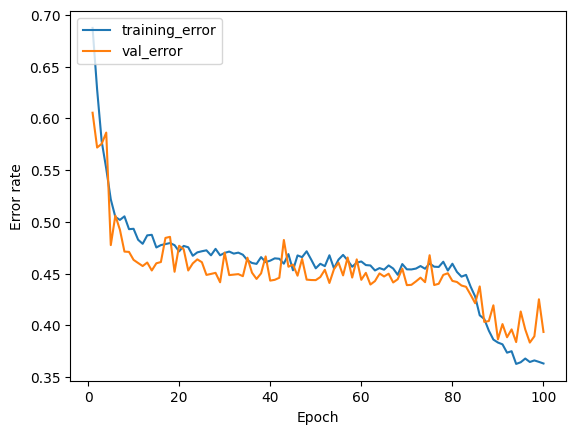

action
{'TP': 0, 'TN': 9866, 'FP': 0, 'FN': 657, 'AC_rate': 0.0, 'F1': 0}
comedy
{'TP': 961, 'TN': 7914, 'FP': 368, 'FN': 1280, 'AC_rate': 0.42882641677822403, 'F1': 0.5383753501400561}
documentary
{'TP': 2245, 'TN': 7117, 'FP': 690, 'FN': 471, 'AC_rate': 0.8265832106038291, 'F1': 0.7945496372323483}
drama
{'TP': 2364, 'TN': 5245, 'FP': 2266, 'FN': 648, 'AC_rate': 0.7848605577689243, 'F1': 0.6186862077990055}
horror
{'TP': 811, 'TN': 8603, 'FP': 818, 'FN': 291, 'AC_rate': 0.735934664246824, 'F1': 0.5939216404247528}
thriller
{'TP': 0, 'TN': 9728, 'FP': 0, 'FN': 795, 'AC_rate': 0.0, 'F1': 0}


In [27]:
# 1.3 part i)
model = SimpleNeuralNet(1, 64)

model = model.to(device)

get_stats(model, 100,True)


**action**
{'TP': 0, 'TN': 9866, 'FP': 0, 'FN': 657, 'AC_rate': 0.0, 'F1': 0}

**comedy**
{'TP': 1405, 'TN': 7415, 'FP': 867, 'FN': 836, 'AC_rate': 0.627, 'F1': 0.623}

**documentary**
{'TP': 2222, 'TN': 7142, 'FP': 665, 'FN': 494, 'AC_rate': 0.818, 'F1': 0.793}

**drama**
{'TP': 1989, 'TN': 6069, 'FP': 1442, 'FN': 1023, 'AC_rate': 0.660, 'F1': 0.617}

**horror**
{'TP': 924, 'TN': 8412, 'FP': 1009, 'FN': 178, 'AC_rate': 0.838, 'F1': 0.609}

**thriller**
{'TP': 0, 'TN': 9728, 'FP': 0, 'FN': 795, 'AC_rate': 0.0, 'F1': 0}

EPOCH 0
Training error: 0.701987087726593
Validation error: 0.7418987154960632
EPOCH 1
Training error: 0.63670414686203
Validation error: 0.5946022868156433
EPOCH 2
Training error: 0.5765709280967712
Validation error: 0.5616269111633301
EPOCH 3
Training error: 0.5603932738304138
Validation error: 0.5306471586227417
EPOCH 4
Training error: 0.5450478792190552
Validation error: 0.5314074158668518
EPOCH 5
Training error: 0.514149010181427
Validation error: 0.5411954522132874
EPOCH 6
Training error: 0.48533084988594055
Validation error: 0.5124964118003845
EPOCH 7
Training error: 0.4724823236465454
Validation error: 0.5523139834403992
EPOCH 8
Training error: 0.4528194069862366
Validation error: 0.4536729156970978
EPOCH 9
Training error: 0.4474615156650543
Validation error: 0.4704931974411011
EPOCH 10
Training error: 0.43861839175224304
Validation error: 0.44493016600608826
EPOCH 11
Training error: 0.43679773807525635
Validation error: 0.49244511127471924
EPOCH 12
Training error: 0.4274344444

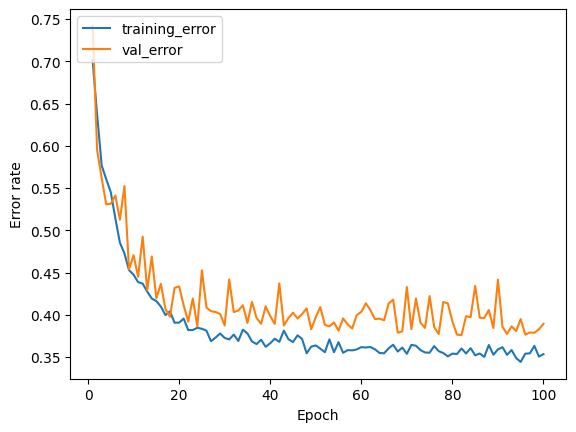

action
{'TP': 0, 'TN': 9866, 'FP': 0, 'FN': 657, 'AC_rate': 0.0, 'F1': 0}
comedy
{'TP': 1368, 'TN': 7418, 'FP': 864, 'FN': 873, 'AC_rate': 0.6104417670682731, 'F1': 0.6116700201207244}
documentary
{'TP': 2316, 'TN': 6935, 'FP': 872, 'FN': 400, 'AC_rate': 0.8527245949926362, 'F1': 0.7845528455284553}
drama
{'TP': 1775, 'TN': 6384, 'FP': 1127, 'FN': 1237, 'AC_rate': 0.5893094289508632, 'F1': 0.6002705444707475}
horror
{'TP': 967, 'TN': 8187, 'FP': 1234, 'FN': 135, 'AC_rate': 0.8774954627949183, 'F1': 0.5855283075991523}
thriller
{'TP': 0, 'TN': 9728, 'FP': 0, 'FN': 795, 'AC_rate': 0.0, 'F1': 0}


In [7]:
model = SimpleNeuralNet(2, 32)

model = model.to(device)

get_stats(model, 100, True)

**action**
{'TP': 0, 'TN': 9866, 'FP': 0, 'FN': 657, 'AC_rate': 0.0, 'F1': 0}

**comedy**
{'TP': 1350, 'TN': 7432, 'FP': 850, 'FN': 891, 'AC_rate': 0.602, 'F1': 0.608}

**documentary**
{'TP': 2208, 'TN': 7153, 'FP': 654, 'FN': 508, 'AC_rate': 0.813, 'F1': 0.792}

**drama**
{'TP': 1985, 'TN': 6048, 'FP': 1463, 'FN': 1027, 'AC_rate': 0.659, 'F1': 0.615}

**horror**
{'TP': 952, 'TN': 8360, 'FP': 1061, 'FN': 150, 'AC_rate': 0.864, 'F1': 0.611}

**thriller**
{'TP': 0, 'TN': 9728, 'FP': 0, 'FN': 795, 'AC_rate': 0.0, 'F1': 0}

EPOCH 0
Training error: 0.692415714263916
Validation error: 0.7413285374641418
EPOCH 1
Training error: 0.5993549823760986
Validation error: 0.6517152786254883
EPOCH 2
Training error: 0.5629941821098328
Validation error: 0.5519338846206665
EPOCH 3
Training error: 0.5215355753898621
Validation error: 0.5917513966560364
EPOCH 4
Training error: 0.4872035086154938
Validation error: 0.48702841997146606
EPOCH 5
Training error: 0.4697253406047821
Validation error: 0.4655516445636749
EPOCH 6
Training error: 0.43913859128952026
Validation error: 0.4381830394268036
EPOCH 7
Training error: 0.4298273026943207
Validation error: 0.425829142332077
EPOCH 8
Training error: 0.42363712191581726
Validation error: 0.43666255474090576
EPOCH 9
Training error: 0.41364961862564087
Validation error: 0.408343642950058
EPOCH 10
Training error: 0.3929463028907776
Validation error: 0.4341917634010315
EPOCH 11
Training error: 0.40376612544059753
Validation error: 0.4940606355667114
EPOCH 12
Training error: 0.39258217

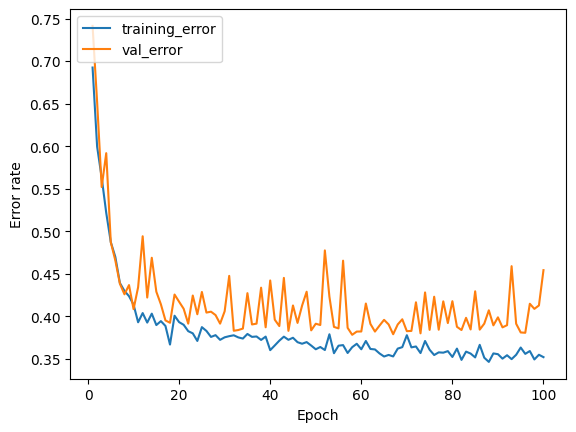

action
{'TP': 0, 'TN': 9866, 'FP': 0, 'FN': 657, 'AC_rate': 0.0, 'F1': 0}
comedy
{'TP': 1542, 'TN': 6921, 'FP': 1361, 'FN': 699, 'AC_rate': 0.6880856760374833, 'F1': 0.599533437013997}
documentary
{'TP': 2428, 'TN': 6478, 'FP': 1329, 'FN': 288, 'AC_rate': 0.8939617083946981, 'F1': 0.7501931098408775}
drama
{'TP': 747, 'TN': 7221, 'FP': 290, 'FN': 2265, 'AC_rate': 0.24800796812749004, 'F1': 0.36897999506050877}
horror
{'TP': 984, 'TN': 7845, 'FP': 1576, 'FN': 118, 'AC_rate': 0.8929219600725953, 'F1': 0.537411250682687}
thriller
{'TP': 42, 'TN': 9504, 'FP': 224, 'FN': 753, 'AC_rate': 0.052830188679245285, 'F1': 0.07917059377945335}


In [8]:
model = SimpleNeuralNet(2, 64)

model = model.to(device)

get_stats(model, 100, True)

**action**
{'TP': 0, 'TN': 9866, 'FP': 0, 'FN': 657, 'AC_rate': 0.0, 'F1': 0}

**comedy**
{'TP': 1274, 'TN': 7566, 'FP': 716, 'FN': 967, 'AC_rate': 0.568, 'F1': 0.602}

**documentary**
{'TP': 2342, 'TN': 6924, 'FP': 883, 'FN': 374, 'AC_rate': 0.862, 'F1': 0.788}

**drama**
{'TP': 2065, 'TN': 5748, 'FP': 1763, 'FN': 947, 'AC_rate': 0.686, 'F1': 0.604}

**horror**
{'TP': 846, 'TN': 8787, 'FP': 634, 'FN': 256, 'AC_rate': 0.768, 'F1': 0.655}

**thriller**
{'TP': 0, 'TN': 9728, 'FP': 0, 'FN': 795, 'AC_rate': 0.0, 'F1': 0}

All 3 models had similar accuracy scores, but the accuracy of the model using 2 layers with 64 nodes was noticeably higher than the other two.
Note it wasn't much higher, just different enough to where it could be classified as an actual improvement rather than a difference that could be classified as noise. This leads me to believe that the most important factor in a neural network's accuracy is the number of nodes it has, which makes sense as a larger number of nodes can capture more intricate relationships between the inputs.

At the same time, the difference in accuracy between training and validation sets is much higher with this model than the other two, leading me to believe that it may actually be overfitted to the training set.

In [19]:
# 1.d
class GoodNeuralNet(nn.Module):
    def __init__(self, num_layers, num_nodes):
        super().__init__()
        layers = []

        prev_size = 300
        for _ in range(num_layers):
            layers.append(nn.Linear(prev_size, num_nodes, dtype=torch.float64))
            layers.append(nn.ReLU())
            prev_size = num_nodes

        layers.append(nn.Linear(prev_size, 6, dtype=torch.float64)) # Output layer
        layers.append(nn.Sigmoid())

        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.stack(x)
        return logits

    def custom_train(self, dataloader, learning_rate, num_epochs, v_feature_tensor, v_label_tensor):
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        train_error_list = []
        validation_error_list = []

        for i in range(num_epochs):
            running_error = 0
            running_sum = 0
            for inputs, label in dataloader:
                output = self(inputs)
                loss = loss_func(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_error += torch.count_nonzero(torch.abs(torch.argmax(output, -1) - label))
                running_sum += len(inputs)


            # report train and validation loss
            validation_output = self(v_feature_tensor)
            train_error_list.append((running_error/running_sum).cpu())
            validation_error_list.append((torch.count_nonzero(torch.abs(torch.argmax(validation_output, -1) - v_label_tensor))/len(v_feature_tensor)).cpu())
            print(f"EPOCH {i}")
            print(f"Training error: {train_error_list[-1]}")
            print(f"Validation error: {validation_error_list[-1]}")

        return train_error_list, validation_error_list

EPOCH 0
Training error: 0.690126895904541
Validation error: 0.7418987154960632
EPOCH 1
Training error: 0.642166018486023
Validation error: 0.5913712978363037
EPOCH 2
Training error: 0.48007699847221375
Validation error: 0.4435046911239624
EPOCH 3
Training error: 0.44002288579940796
Validation error: 0.45671385526657104
EPOCH 4
Training error: 0.4227527976036072
Validation error: 0.46631190180778503
EPOCH 5
Training error: 0.4159384071826935
Validation error: 0.41109949350357056
EPOCH 6
Training error: 0.4052746593952179
Validation error: 0.4231683015823364
EPOCH 7
Training error: 0.40100914239883423
Validation error: 0.41993728280067444
EPOCH 8
Training error: 0.39632749557495117
Validation error: 0.3963698446750641
EPOCH 9
Training error: 0.39674365520477295
Validation error: 0.4238335192203522
EPOCH 10
Training error: 0.3855077028274536
Validation error: 0.40872374176979065
EPOCH 11
Training error: 0.37697669863700867
Validation error: 0.39969590306282043
EPOCH 12
Training error: 0.3

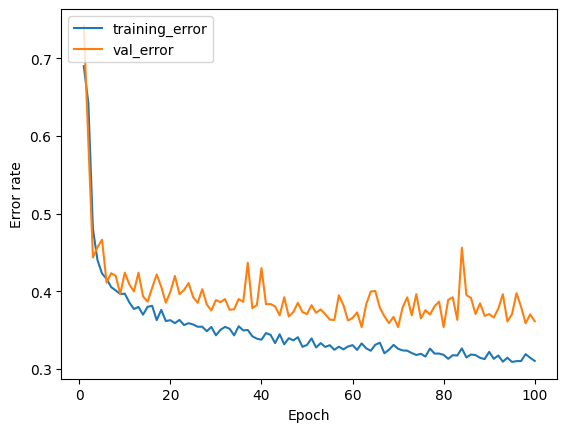

action
{'TP': 194, 'TN': 9759, 'FP': 107, 'FN': 463, 'AC_rate': 0.2952815829528158, 'F1': 0.40501043841336115}
comedy
{'TP': 1525, 'TN': 7226, 'FP': 1056, 'FN': 716, 'AC_rate': 0.680499776885319, 'F1': 0.6325176275404397}
documentary
{'TP': 2435, 'TN': 6704, 'FP': 1103, 'FN': 281, 'AC_rate': 0.896539027982327, 'F1': 0.778701630956188}
drama
{'TP': 1514, 'TN': 6806, 'FP': 705, 'FN': 1498, 'AC_rate': 0.50265604249668, 'F1': 0.5788568151405085}
horror
{'TP': 857, 'TN': 8890, 'FP': 531, 'FN': 245, 'AC_rate': 0.7776769509981851, 'F1': 0.6883534136546186}
thriller
{'TP': 196, 'TN': 9428, 'FP': 300, 'FN': 599, 'AC_rate': 0.24654088050314465, 'F1': 0.30364058869093724}
tensor([5, 3, 3,  ..., 2, 2, 3])
       0
0      5
1      3
2      3
3      3
4      3
...   ..
10518  6
10519  2
10520  2
10521  2
10522  3

[10523 rows x 1 columns]


In [25]:
model = GoodNeuralNet(2, 512)

model = model.to(device)

get_stats(model, 100, False)

prediction = model(torch.unsqueeze(t_feature_tensor, 1))

prediction_index = torch.argmax(torch.squeeze(prediction, 1), -1).cpu()

prediction_index = torch.add(prediction_index, 1)
print(prediction_index)

prediction_np = prediction_index.numpy()
prediction_df = pd.DataFrame(prediction_np)
print(prediction_df)
prediction_df.to_csv("submission.csv", index=True, header=["label"])

1c.
The good version of the neural net simply takes the trends that were observed in the simple neural nets: a larger number of nodes lead to better accuracy, but a larger number of layers lead to overfitting.

This suggests that for this particular dataset, the value of each dimension plays a large role in the correct classification, rather than the relationship between dimensions. Thus, neural net that is very wide and shallow is best, as it can capture each dimension and weigh it's importance, without getting lost in the relationships between dimensions, causing convoluted results.

Note: the good neural net submitted on learn may not be the same neural net as the one submitted on Kaggle. I intend to continue to try and improve the neural net until the day the kaggle competition closes.

2e.
With more time, money, and resources, I would continue to expand the neural network. With more nodes and trying different numbers of layers, I would eventually be able to find an optimal node configuration to achieve the best accuracy on this dataset. This is more of an issue with resources than one of time or money; the system I am testing this on does not have the capacity to train more complex neural networks.